# Chromatix 101

Chromatix is a library for simulating wave optics intended to be used for computational optics research. Chromatix allows for modeling of optical systems by composing together a set of optical elements in a manner similar to composing the layers of a neural network in a deep learning library. Much like a deep learning library, each optical element comes with support for autodifferentiation and runs on (potentially more than one) GPU, thanks to [JAX](https://github.com/google/jax). All of these make Chromatix a great fit for solving inverse problems in optics, such as phase retrieval or designing custom diffractive elements.

We'll go through a high level overview of Chromatix, demonstrating the two different styles Chromatix offers to model optical systems and highlighting a few of its capabilities along the way. We won't cover every detail of the library, but by the end of the notebook you should know where to look to find those details and also have an understanding of how all the pieces of the library fit together.

In [4]:
from typing import Optional
from functools import partial
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from chex import Array
from einops import rearrange
import matplotlib.pyplot as plt
import chromatix.functional as cx
from chromatix import Field, ScalarField
from chromatix.systems import OpticalSystem, Microscope, Optical4FSystemPSF
from chromatix.elements import PlaneWave, FFLens, ThinSample, BasicSensor, trainable
from chromatix.utils import siemens_star
from chromatix.utils.initializers import seidel_aberrations, zernike_aberrations

## Fields

### Creating a Field

Chromatix represents electric fields with the `Field` class. A `Field` describes not just the complex field in a 2D plane, but also keeps track of the spacing of the field (how far apart the centers of two pixels in a `Field` are) as well as the spectrum of the `Field`. `Field`s are further subclassed into `ScalarField` and `VectorField`, which either use the scalar approximation or the full vectorial simulation of a field respectively. In this notebook, we'll deal with `ScalarField`s for simplicity, but everything that we show will also apply to `VectorField`s.

*Every* optical element in Chromatix deals with `Field`s, typically accepting an incoming `Field`, transforming it in some way, and then outputting the transformed `Field`. These transformations can include lenses, phase masks like spatial light modulators, aberrations, samples, propagations, etc.

Let's take a look at how to create a `Field` and go through its attributes and some of the operations you can perform:

In [5]:
# Create a monochromatic plane wave
field = cx.plane_wave(shape=(512, 512), dx=0.3, spectrum=0.532, spectral_density=1.0)
print(f"shape of field: {field.shape}")
print(f"spectrum: {field.spectrum}\nspectral density: {field.spectral_density}")
print(f"power: {field.power}")
print(f"shape of intensity: {field.intensity.shape}\nshape of phase: {field.phase.shape}")

shape of field: (1, 512, 512, 1, 1)
spectrum: [[[[[0.532]]]]]
spectral density: [[[[[1.]]]]]
power: [[[[[1.0000004]]]]]
shape of intensity: (1, 512, 512, 1, 1)
shape of phase: (1, 512, 512, 1, 1)


Here we've called a Chromatix function to create a monochromatic plane wave. As you can see, defining a `Field` requires you to specify at least the 2D shape, the spacing of pixels (`dx`), the wavelengths in the spectrum (`spectrum`), and also the spectral density (`spectral_density`) --- the weight or intensity of each wavelength in the spectrum, which will be normalized to sum to 1). **Note that all of the units must match!** Here, we've input everything in microns.

As you can see, the `Field` has a few empty dimensions. The shape of a `Field` in general is `(B ... H W C [1 | 3])`. The first dimension, `B`, is the batch dimension. This can be used as a depth axis for 3D samples or a batch of different `Field`s, and any operation provided by Chromatix will operate on all entries of the batch dimension in parallel. The `...` specifies that you can actually have an arbitrary number of batch dimensions, which is useful for batches of 3D `Field`s, but there will always be at least 1. The next two dimensions, `H W`, represent the height and width of the `Field` in a 2D plane. Then, we have the channel dimension `C`, which stores a `Field` of each wavelength in the spectrum independently. These are also treated independently and in parallel by most of Chromatix, meaning we treat these as fully coherent `Field`s. In this case, we have one wavelength so `C = 1`. Finally, we have the dimension that is either an empty dimension for `ScalarField`s or stores the three spatial components (Z, Y, and X) for `VectorField`s. We keep this empty dimension around in `ScalarField` so that we can take advantage of broadcasting instead of checking types throughout the library.

You'll also notice that all the attributes of the `Field`, e.g. its intensity or even the spacing and spectrum which we provided manually, have also been reshaped so that they will broadcast appropriately when needed in any computations with the actual `Field` itself.

In addition to creating specific kinds of `Field`s like the plane wave above, you can also create a `Field` directly using the corresponding class method for either `ScalarField` or `VectorField`. These can accept either a shape or a complex valued array with any values you want, as long as this array has at least 5 dimensions of the form `(B ... H W C [1 | 3])`:

In [6]:
# A flat, monochromatic  field
field = ScalarField.create(
    dx=0.3,
    spectrum=0.532,
    spectral_density=1.0,
    u=jnp.ones((1, 512, 512, 1, 1)) * jnp.exp(1j)
)
# An uninitialized Field with two wavelengths in its spectrum
field = ScalarField.create(
    dx=[0.3, 0.4],
    spectrum=[0.532, 0.512],
    spectral_density=[0.8, 0.2],
    shape=(512, 512)
)
# field = ScalarField.create(u=jnp.ones((512, 512)) * jnp.exp(1j)) # This line will error!

### Manipulating a Field

The actual JAX `Array` representing a `Field` can be found using `field.u`. However, as we've mentioned, every optical element described in Chromatix can handle `Field`s. For example, we can propagate a plane wave that has passed through a square aperture for 50 microns:

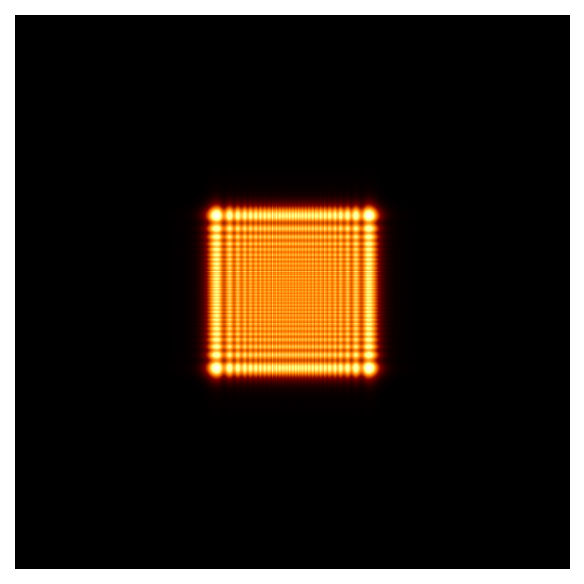

In [7]:
field = cx.plane_wave(shape=(512, 512), dx=0.3, spectrum=0.532, spectral_density=1.0)
field = cx.square_pupil(field, w=50.0)
field = cx.transfer_propagate(field, z=50.0, n=1.33, N_pad=0)
fig = plt.figure(dpi=150)
plt.imshow(field.intensity.squeeze(), cmap="afmhot")
plt.axis("off")
plt.show()

You can also manipulate a `Field` directly with all the arithmetic operations available in Python, as long as what you're doing broadcasts as intended to the shape of the `Field`. This is intended for convenience, but keep in mind that **there are no checks performed when doing this** so you can create invalid results!

In [8]:
field = cx.plane_wave(shape=(512, 512), dx=0.3, spectrum=0.532, spectral_density=1.0)
field *= 5
field = 0 - field
field = field + jnp.ones((1, 512, 512, 1, 1))
# Be careful with broadcasting! This line creates an invalid Field
# with 100 wavelengths and 100 spatial components.
# field = field + jnp.ones((100, 100))

### Visualizing a Field

For any `Field`, you can grab the intensity and phase in order to visualize it. Here's a plane wave propagating at an angle to the propagation axis:

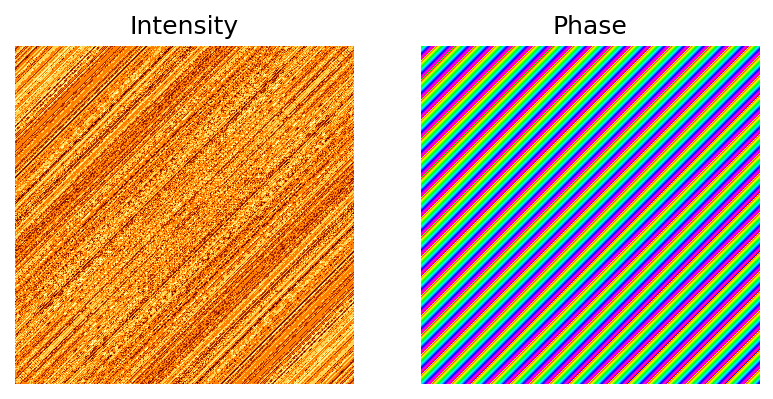

In [10]:
field = cx.plane_wave(shape=(512, 512), dx=0.3, spectrum=0.532, spectral_density=1.0, kykx=[1/jnp.sqrt(2), 1/jnp.sqrt(2)])
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150)
ax = axes[0]
ax.imshow(field.intensity[0].squeeze(), cmap="afmhot") # Intensity of first element of batch
ax.axis("off")
ax.set_title("Intensity")
ax = axes[1]
ax.imshow(field.phase[0].squeeze(), cmap="hsv") # Phase of first wavelength of first batch element
ax.axis("off")
ax.set_title("Phase")
plt.show()

## Modeling optical systems in Chromatix

<div class="admonition warning">
  <p class="admonition-title">Warning</p>
  <p>
    A lot of the code we're showing here is calling JAX functions directly.
    Usually, you should use <code>jax.jit</code> to compile a system in order to
    make the simulation faster. Otherwise, you might find that a simulation
    appears to run very slowly. We'll show what it looks like to use
    <code>jax.jit</code> later on, but also see the
    <a href="https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html">JAX documentation</a>.
  </p>
</div>

So far, we've been looking at quick, one-off simulations. But that doesn't really make it very easy to optimize parameters of optical elements. Instead, we'd usually like to have some way to bundle a bunch of optical elements provided by Chromatix together into a system, so that initialization of trainable parameters and other state is well handled and usable by Flax and optimizer libraries like Optax. We'll take a look at how to build simulations in Chromatix in two different styles: (1) as a sequence of optical elements, organized much like you would imagine placing physical elements, and (2) as an abstracted microscope that will take intensity measurements and simulate imaging of intensity samples using a point spread function. We'll talk about when you would want to use either style of simulation in their respective sections.

### Chromatix functional API vs Chromatix elements

Before we get to that, we'll have to talk about optical elements in Chromatix. Everything we've shown so far has been performed using functions. These form the functional API of Chromatix, which builds on top of `Field`s and defines many useful optical simulations that can handle them, as you've just seen. The rest of Chromatix is then built on top of these `Field`-manipulating functions.

That means that Chromatix provides both a functional core API, which is convenient for quick experimentation or visualization, as well as a set of element classes around these functions that assist with defining and managing parameters and state. This functional API is convenient for demonstrations, like this notebook. However, when you know what you want to simulate and are looking for a convenient way to describe a system, e.g. when you want to optimize something, you can use Chromatix elements. Of course, you are free to use a combination of both in any way you please!

Chromatix elements are all Flax `nn.Module`s, meaning they act like neural network layers. There are two difference between a normal neural network layer and a Chromatix element: (1) elements act on `Field`s rather than just `Array`s and (2) you have to choose which attributes of an element should be parameters and which should not, unlike a neural network layer where it is obvious what to optimize. By default, nothing will be optimizable.

In [11]:
# Create a plane wave source as an element
plane_wave_source = PlaneWave(shape=(512, 512), dx=0.3, spectrum=0.532, spectral_density=1.0)
# NOTE: We have to initialize any parameters or state,
# which always requires a PRNGKey even if there is
# no randomness to the initialization.
variables = plane_wave_source.init(random.PRNGKey(42))
print(variables)
# Now we can create a plane wave:
field = plane_wave_source.apply(variables)
print(f"field shape: {field.shape}\nfield power: {field.power}")

{'state': {'_kykx': (0.0, 0.0), '_power': 1.0, '_amplitude': 1.0}}
field shape: (1, 512, 512, 1, 1)
field power: [[[[[1.0000004]]]]]


Note that as a Flax `nn.Module`, we have to explicitly initialize some state. If we peek inside this `variables` dictionary, we'll see there is only a `"state"` key, because this element has no trainable parameters. For more details on these `variables`, see the [Flax documentation](https://flax.readthedocs.io/en/latest/guides/flax_basics.html#module-parameters).

This is certainly awkward for just a single function call and no trainable parameters, but will become more useful once you have lots of elements with trainable parameters all working together, and potentially as submodules to a larger `nn.Module`. Let's see what happens if we have some trainable parameters in an element. We won't talk about how this works in detail here, but see the [documentation on making attributes of elements trainable](https://chromatix.readthedocs.io/en/latest/api/utils/#chromatix.utils.utils.trainable) for more. We will, however, be demonstrating optimization in the last section of this document --- but also see the [documentation on training](https://chromatix.readthedocs.io/en/latest/training/) for more details.

In [12]:
# Create a plane wave source as an element
plane_wave_source = PlaneWave(shape=(512, 512), dx=0.3, spectrum=0.532, spectral_density=1.0, kykx=trainable(jnp.zeros((2,))))
# NOTE: We have to initialize any parameters or state,
# which always requires a PRNGKey even if there is
# no randomness to the initialization.
variables = plane_wave_source.init(random.PRNGKey(42))
print(variables)
# Now we can create a plane wave:
field = plane_wave_source.apply(variables)
print(f"field shape: {field.shape}\nfield power: {field.power}")

{'params': {'_kykx': Array([0., 0.], dtype=float32)}, 'state': {'_power': 1.0, '_amplitude': 1.0}}
field shape: (1, 512, 512, 1, 1)
field power: [[[[[1.0000004]]]]]


We've now marked some of the state of this element, the ky and kx vectors that determine the angle of the plane wave, as trainable. This has introduced the new `"params"` key to the `variables` dictionary. We could pass this `"params"` dictionary to an Optax optimizer if we chose to optimize this value. But it isn't very useful to look at just a single element, so let's start building more complicated systems!

### Modeling an optical system as a sequence of optical elements

Before we start, let's get some data that we want to use to simulate things with. We'll go with a simple Siemens star, which Chromatix has a utility function to generate:

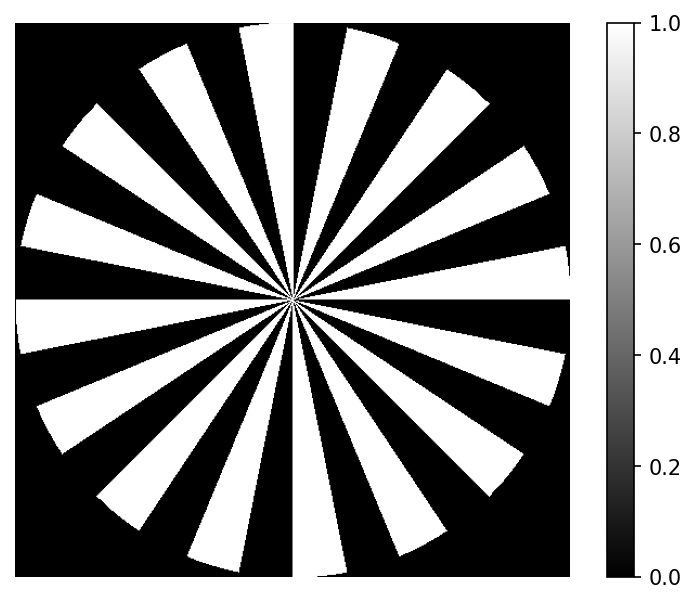

In [13]:
star = siemens_star(512)
fig = plt.figure(dpi=150)
plt.imshow(star, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()

We'll simulate taking an image of this sample using a 4f system that has some defocus. We'll model the defocus using a phase mask. Let's also start with the most straightforward (and flexible!) way of creating a simulation. We'll build an `nn.Module` and call the functions that we want directly. Let's see what that looks like:

In [14]:
class ImagingSystem(nn.Module):
    sample: Array
    f: int = 100.0
    n: int = 1.0
    NA: int = 0.8
    
    @nn.compact
    def __call__(self) -> Array:
        field = PlaneWave(shape=(512, 512), dx=0.3, spectrum=0.532, spectral_density=1.0)()
        field = ThinSample(
            absorption=jnp.zeros_like(self.sample),
            dn=trainable(self.sample),
            thickness=1.0,
        )(field)
        field = FFLens(self.f, self.n)(field)
        field = FFLens(self.f, self.n, self.NA)(field)
        image = BasicSensor(
            shape=(256, 256),
            spacing=0.6,
            reduce_axis=0,
            shot_noise_mode=None
        )(field)
        return image

Here, we've modeled an imaging system that illuminates a thin phase sample with a plane wave, followed by a simple 4f system to image the result. We've included a sensor that for now we'll set to have no noise to keep things simple. The sensor also resamples the incoming field to its pixels, which we've defined to have half the resolution of the system.

The system is set up to interpret the given sample as a phase only term, i.e. the sample is interpreted as a refractive index distribution that will produce a phase contrast image.

In [15]:
# Creates the imaging system and initializes the system
# with the sample we want to image.
system = ImagingSystem(sample=rearrange(star, "h w -> 1 h w 1 1"))
# Initialize the parameters and state of the imaging system,
# which always requires a key to initialize random numbers even
# if there is no randomness involved in the model.
variables = system.init(rngs=random.PRNGKey(4))
# Finally, use the parameters and state to run the model.
image = system.apply(variables).squeeze()

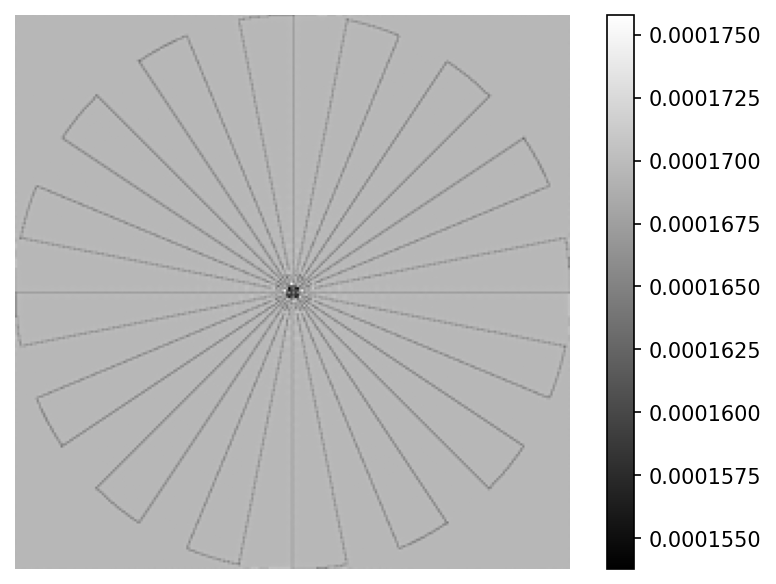

In [16]:
fig = plt.figure(dpi=150)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()

We see that we've got an image of our phase only sample illuminated by a plane wave. We could play with the angle of the plane wave and observe what happens to the resulting image, but first let's also take a look at how we can simplify the creation of the imaging system.

Most systems we will want to describe are a sequence of optical elements, such as illumination sources, samples, lenses, etc. Chromatix provides a convenient way to bundle these elements into a sequential system of optical elements: the `OpticalSystem`. This class allows you to provide a list of optical elements from Chromatix and have Chromatix pass the field from element to element, returning to you the result. In this case, we've placed a sensor at the end so we'll receive an intensity array, but the result could just as easily have been a `Field`. Let's see what it looks like to define an `OpticalSystem` in Chromatix:

In [17]:
sample = rearrange(star, "h w -> 1 h w 1 1")
system = OpticalSystem(
    [
        PlaneWave(shape=(512, 512), dx=0.3, spectrum=0.532, spectral_density=1.0),
        ThinSample(
            absorption=jnp.zeros_like(sample),
            dn=trainable(sample),
            thickness=1.0
        ),
        FFLens(f=100.0, n=1.0),
        FFLens(f=100.0, n=1.0, NA=0.8),
        BasicSensor(
            shape=(256, 256), spacing=0.6, reduce_axis=0, shot_noise_mode=None)
    ]
)
variables = system.init(rngs=random.PRNGKey(4))
image = system.apply(variables).squeeze()

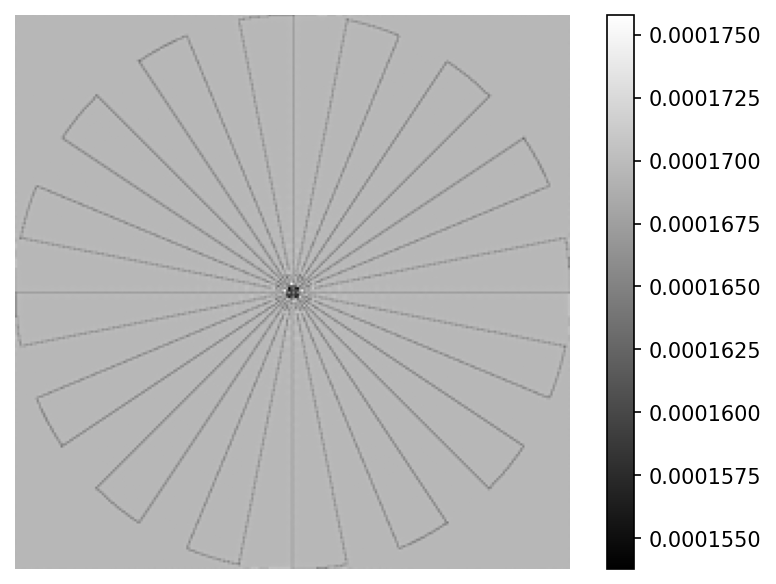

In [18]:
fig = plt.figure(dpi=150)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()

And we see that the result is exactly the same as what we simulated with our original `nn.Module` class. So in just a few lines of code, we described an optical system to Chromatix and got a simulated result!

But this style of describing a simulation has given us conciseness in exchange for flexibility. In the class we wrote ourselves, we could have called any function we wanted and manipulated the `Field` in any way we wanted. For example, you could use the functional Chromatix API in the class version to call `cx.thin_sample` instead of using the element, and then also take `sample` as an argument in order to simulate different samples every time.

Of course, the ability to write a custom `nn.Module` is available to you at any time. However, Chromatix also provides another convenient style for describing systems that are spatially invariant: `Microscope`s. Moreover, this style of simulation allows you to simulate an incoherent sample (e.g. a fluorescent sample) as opposed to the fully coherent simulation that we performed above.

### Modeling an optical system as a spatially invariant microscope

A `Microscope` lets you plug in an `nn.Module` that computes the point spread function (PSF) of the sytem and also the sensor that you want to use. Given these two things, the `Microscope` computes the PSF, then performs a convolution between a given sample and the PSF. The `Microscope` takes samples as an input argument as opposed to an attribute, so you can image multiple samples with the same PSF more easily than how we imaged a sample above. Chromatix also provides common descriptions of system PSFs, e.g. the PSF for a 4f system. We'll use that system and initialize it with an aberrated phase mask to introduce some defocus to the system. Let's see what it looks like to define and image our Siemens star sample as an incoherent intensity sample (as if it were made of fluorescent particles):

In [20]:
microscope = Microscope(
    # Define the PSF for a 4f system
    system_psf=Optical4FSystemPSF(
        shape=(512, 512),
        spacing=0.3,
        # We want to introduce some aberrations, which we can do
        # using the phase mask of the 4f system. We'll add some
        # defocus aberration using the Zernike polynomials, which
        # are built in to Chromatix.
        phase=trainable(
            partial(
                zernike_aberrations,
                ansi_indices=[0, 1, 2, 3, 4],
                coefficients=[0, 0, 0, 0, 20]),
            rng=False # Because zernike_aberrations doesn't need a PRNGKey
        )
    ),
    # Define the sensor we want to image with
    sensor=BasicSensor(
        shape=(512, 512),
        spacing=0.3,
        shot_noise_mode="poisson", # This time, we simulate shot noise
        reduce_axis=0 # If None, returns a batch of 2D images
    ),
    f=100.0,
    n=1.0,
    NA=0.8,
    spectrum=0.532,
    spectral_density=1.0
)
variables = microscope.init({"params": random.PRNGKey(4), "noise": random.PRNGKey(5)}, sample, 0)
image = microscope.apply(variables, star[None, ..., None, None], 0, rngs={"noise": random.PRNGKey(5)}).squeeze()
psf = microscope.apply(variables, 0, method=microscope.psf, rngs={"noise": random.PRNGKey(5)}).intensity.squeeze()

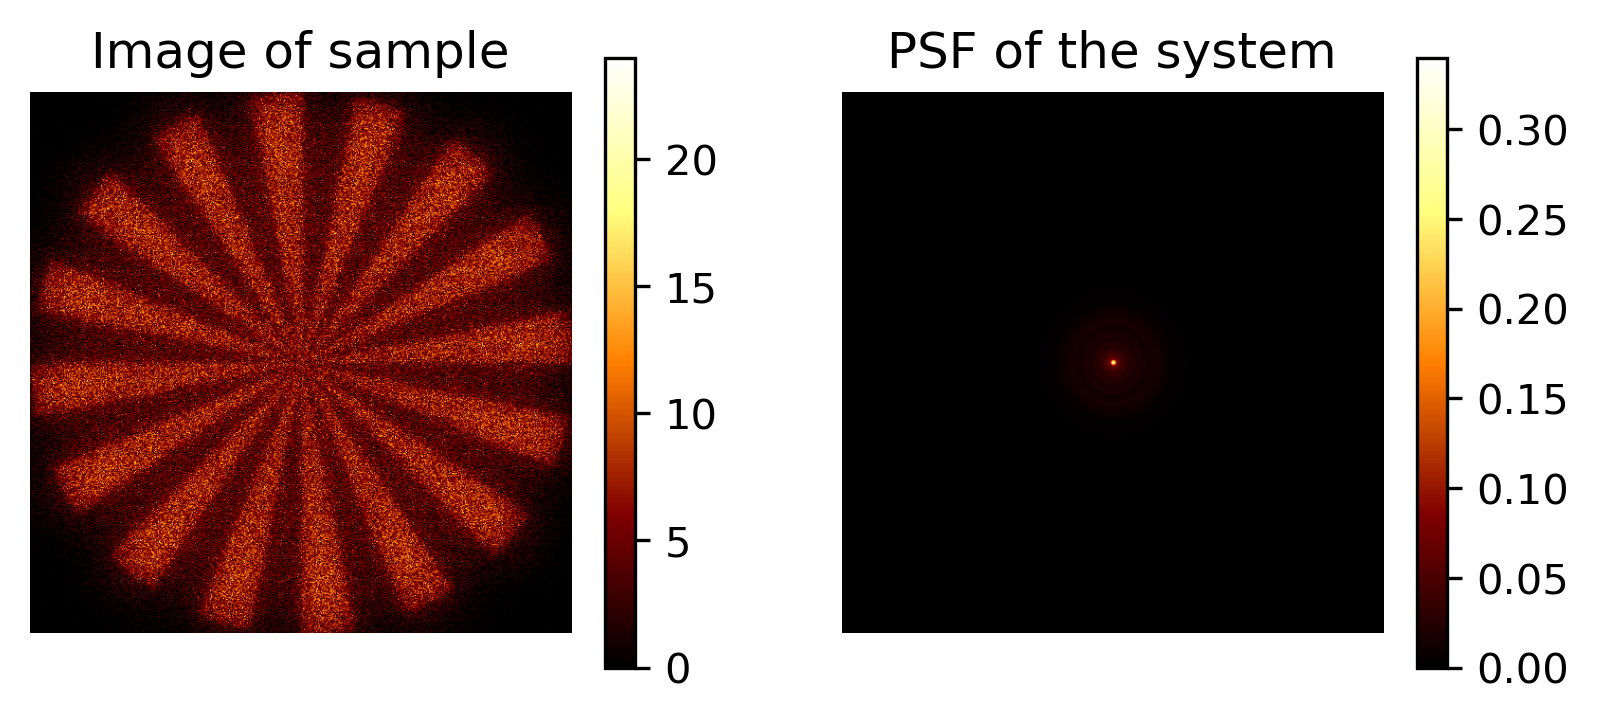

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
ax = axes[0]
im_handle = ax.imshow(image, cmap="afmhot")
fig.colorbar(im_handle, ax=ax, shrink=0.55)
ax.axis("off")
ax.set_title("Image of sample")
ax = axes[1]
im_handle = ax.imshow(psf ** 0.6, cmap="afmhot")
fig.colorbar(im_handle, ax=ax, shrink=0.55)
ax.axis("off")
ax.set_title("PSF of the system")
plt.show()

We see that with a relatively concise description of a `Microscope` we got a noisy, blurry image of our Siemens star! In order to do this, we have to pass a noise key every time we call the model. We are also able to visualize the PSF of the system by calling the `microscope.psf` function. In the PSF visualization, we can see the effect of adding defocus aberration to the phase of the 4f system.

This style allows for the efficient simulation of incoherent imaging for systems with PSFs, which can be described with any `nn.Module` (though Chromatix attempts to provide the most common systems out of the box).

Chromatix also supports optimizing the parameters of these systems, e.g. the phase mask of the 4f system --- in fact it's really the main purpose of Chromatix. Take a look at the [documentation on optimization](https://chromatix.readthedocs.io/en/latest/training/) as well as some of [our examples](https://chromatix.readthedocs.io/en/latest/examples/dmd/) to see this optimization in action!